# Adherence and Metric Comparison

Author: Serena

Goal = expand on previous work done in `Serena - Metric Analysis` and compare several different methods of processing. 

Focus will be on Serena's QS user data due to explainability, but functions will be developed for reusability so that models can be tested on the other datasets. 

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [6]:
# Is there a way to import functions from another noteook? Read in from readingQS ipynb
def read_QS_data(filename):
    #Read in CSV file
    dat = pd.read_csv(filename)
    #Extract datetime information
    dat["Datetime"] = pd.to_datetime(dat["Start"], format = '%d-%b-%Y %H:%M')
    dat["Date"] = dat["Datetime"].dt.date
    dat["Hour"] = dat["Datetime"].dt.hour
    #Format columns
    dat = dat[["Date", "Hour", "Steps (count)"]]
    dat.columns = ["Date", "Hour", "Steps"]
    
    return dat

def read_Pacer_data(filename):
    #Read in the data
    dat = pd.read_csv(filename)
    #Select necessary columns
    dat = dat[["date","steps"]]
    #Extract datetime data
    dat["datetime"] = pd.to_datetime(dat["date"], format = '%m/%d/%Y, %H:%M:%S %z')
    dat["Date"] = dat["datetime"].dt.date
    dat["Hour"] = dat["datetime"].dt.hour
    dat["Min"] = dat["datetime"].dt.minute
    #Aggregate over the hours
    dat = dat.groupby(["Date","Hour"])["steps"].agg("sum").reset_index()
    #Relabel columns
    dat.columns = [["Date", "Hour", "Steps"]]
    
    return dat


In [7]:
data = read_QS_data("../../data/Participant_ID_C/User3.csv")
data.head()

,Date,Hour,Steps
0,2015-11-28,12,13.0
1,2015-11-28,13,19.0
2,2015-11-28,14,33.0
3,2015-11-28,15,80.0
4,2015-11-28,16,0.0


# Implementing Processing Methods

From our initial brainstorm, there were multiple ways to go with the processing methods:
- 10 hour windows choice
- Time blocks
- Weekend vs Weekday
- Time series
- Adherence measures

I will be experimenting with different adherence measures, because not all days will be representative of the how the user exercises, e.g. I will occasionally go on 10km hikes with friends but that is not the norm. If we kept these data points, any error models (except maybe log) will have an insane error term on outliers. But if we removed them, we may miss out on useful information. E.g. maybe someone goes on a hike once a month on different days. 

---

Metrics for evaluating these processing methods will be:
- How closely we can predict step counts given a bunch of features
- How accurately we can pick up on trends for a given year, month, week, etc. E.g. if I consistently go on walks every Monday morning at 7am, how likely is our analysis going to pick up on that?



In [8]:
data

,Date,Hour,Steps
0,2015-11-28,12,13.000000
1,2015-11-28,13,19.000000
2,2015-11-28,14,33.000000
3,2015-11-28,15,80.000000
4,2015-11-28,16,0.000000
...,...,...,...
42789,2020-10-15,9,17.373512
42790,2020-10-15,10,0.000000
42791,2020-10-15,11,47.000000
42792,2020-10-15,12,0.000000


---

**Adherence Measures** -- i.e. accounting for the fact that some people aren't recording their steps for as long as others. 
- Wear time (Althoff et al): first step recorded to last step recorded for each day.
    - This has the issue of not taking into account people who are nocturnal or have poly-phasic sleep -- e.g. night shift security guards. We don't really have a good reference for this, so for the time being we can assume most people are unaffected by this metric. 
    - Since Althoff et al don't explicitly mention dropping any days where wear time is low, we will keep all data points
- High and Low Activity periods: unique to each person, there will be systematic times during the days/weeks/hours where the person will be more or less active
    - Used for intra-day analysis, where once we determine the expected high and low activity hours/days, we can filter out the days that don't quite fit that mold. 
    - This can definitely backfire though
- Weekend and Weekday adherence: Due to the nature of most work, we expect different behaviours during the weekend vs the weekday
    - Also establishes a baseline level of activity
    
1) One of the tests we'll do (which is more qualitative in nature) is seeing which method of processing shows us the best results. 

2) And then we'll run it through a lin reg and see how accurate those models are

In [9]:
def add_time_features(df):
    df = df.copy()
    df['year'] = df['Start'].dt.year
    df['month'] = df['Start'].dt.month
    df['day'] = df['Start'].dt.day
    df['dayofweek'] = df['Start'].dt.dayofweek
    df['hour'] = df['Start'].dt.hour
    
    return df

In [10]:
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42794 entries, 0 to 42793
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    42794 non-null  datetime64[ns]
 1   Hour    42794 non-null  int64         
 2   Steps   42794 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 1003.1 KB


> What is the difference between the Althoff et al (2017) calculation of step counts with one that requires 10-hours of the day with steps for a small number of users?

???????????

Ok first we're going to see how many days the adherence criteria removes from the dataset

## Seasonality Plots

Because from intuition, adherence may vary based on the year, week, month, etc. So we'll take a look and plot the step count

In [11]:
daily = data.resample("D", on='Date')
daily = daily.agg({'Hour': 'count', 'Steps': 'sum'})
daily

,Hour,Steps
Date,,
2015-11-28,12,145.0
2015-11-29,24,4233.0
2015-11-30,24,4162.0
2015-12-01,24,3209.0
2015-12-02,24,2773.0
...,...,...
2020-10-11,24,7016.0
2020-10-12,24,6555.0
2020-10-13,24,4409.0


In [12]:
daily['Year'] = daily.index.year
daily['Month'] = daily.index.month

In [13]:
years = daily['Year'].unique()


I have found a thing on seasonality, so we're going to look into that first. Breaking up the data by year and plotting the monthly sum of steps

In [14]:
monthly = data.resample("m", on='Date')
monthly = monthly.agg({'Hour': 'count', 'Steps': 'sum'})
monthly['Year'] = monthly.index.year
monthly['Month'] = monthly.index.month
years = monthly['Year'].unique()


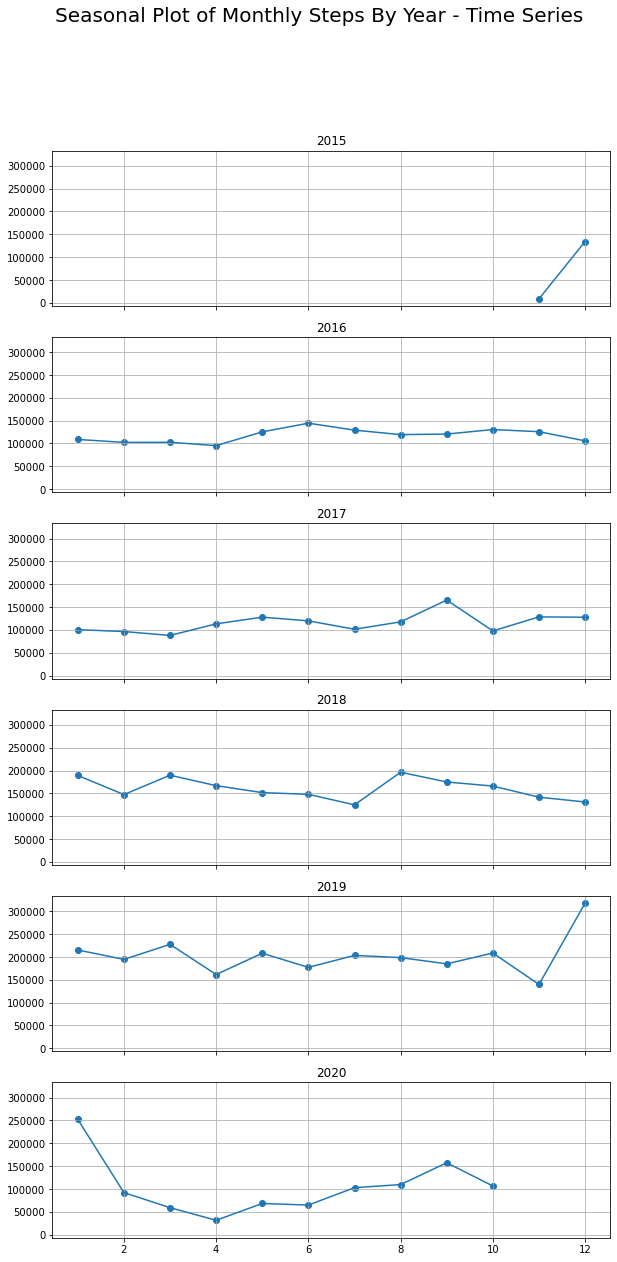

In [15]:
fig, axs = plt.subplots(len(years), sharex = True, sharey=True, figsize=(10,20))

for i, y in enumerate(years):
    axs[i].scatter(monthly[monthly['Year'] == y]['Month'], monthly[monthly['Year'] == y]['Steps'] 
                  )
    axs[i].plot(monthly[monthly['Year'] == y]['Month'], monthly[monthly['Year'] == y]['Steps'] )
    axs[i].grid()
    axs[i].set_title(y)

    # Decoration
plt.suptitle("Seasonal Plot of Monthly Steps By Year - Time Series ", fontsize=20)
plt.show()

From a glance it's clear that there are certain exceptions to step counts-- namely 2015, end of 2019, and 2020-- but otherwise the step counts are rather consistent across the years, deviating by around 50,000 steps (or ~ 1.6k steps a day) throughout the year. 

A couple trends to note and their respective explanations:
- 2016 and 2017 had similar bareline levels of step counts, around 100k-150k steps a month. This is likely because I was in high school, and so had a fairly set schedule. The deviation in Sept 2017 can be attributed to graduation, where I took more walks as study breaks from the HSC
- 2018 saw higher baseline step levels of 150k-200k, attributed to the start of uni and how I commuted to and from Wollongong, and so walked a lot more
- 2019 saw even higher baseline levels of around 200k. I moved on campus that year and walked a lot more to and from uni, as well as grocery shopping and got to participate in more activities. I was also walking to and from work twice a week. 
- End of 2019 and early 2020: I went overseas on exchange, and was consistently walking 10-20k steps a day as part of research, fieldwork, and general tourism. 
- 2020: corona.

---

Now taking a look at some smaller time blocks. Within 2020, let's see the walking breakdown by week for each month.


In [16]:

weekly = data.resample("D", on='Date')
weekly = weekly.agg({'Hour': 'count', 'Steps': 'sum'})
weekly['Year'] = weekly.index.year
weekly['Month'] = weekly.index.month
weekly['Day'] = weekly.index.day
weekly = weekly[weekly['Year'] == 2020]
months = weekly['Month'].unique()


In [17]:
weekly['dow'] = weekly.index.dayofweek
weekly['weekday'] = weekly['dow'].apply(lambda x: True if x <= 4 else False)
weekly

,Hour,Steps,Year,Month,Day,dow,weekday
Date,,,,,,,
2020-01-01,24,4209.000000,2020,1,1,2,True
2020-01-02,24,6168.853029,2020,1,2,3,True
2020-01-03,24,17576.146971,2020,1,3,4,True
2020-01-04,24,15388.000000,2020,1,4,5,False
2020-01-05,24,15694.000000,2020,1,5,6,False
...,...,...,...,...,...,...,...
2020-10-11,24,7016.000000,2020,10,11,6,False
2020-10-12,24,6555.000000,2020,10,12,0,True
2020-10-13,24,4409.000000,2020,10,13,1,True


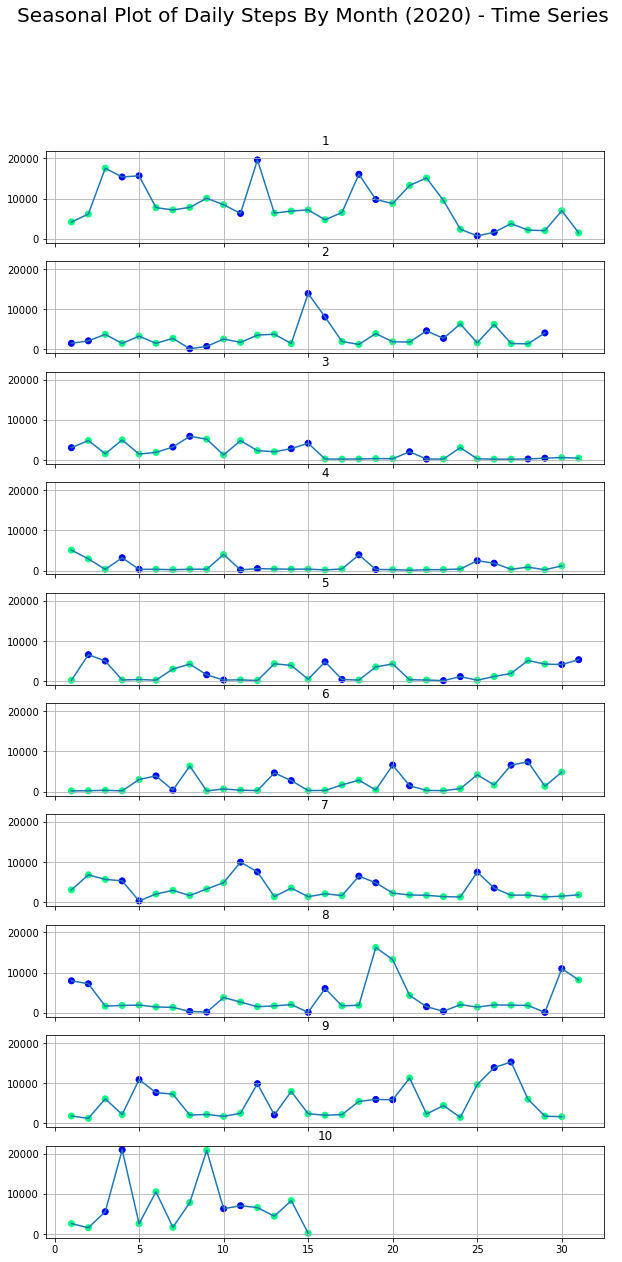

In [18]:
fig, axs = plt.subplots(len(months), sharex = True, sharey=True, figsize=(10,20))

for i, y in enumerate(months):
    axs[i].scatter(weekly[weekly['Month'] == y]['Day'], weekly[weekly['Month'] == y]['Steps'] , 
                   c= weekly[weekly['Month'] == y]['weekday'], cmap = 'winter'
                  )
    axs[i].plot(weekly[weekly['Month'] == y]['Day'], weekly[weekly['Month'] == y]['Steps'])
    axs[i].grid()
    axs[i].set_title(y)

    # Decoration
plt.suptitle("Seasonal Plot of Daily Steps By Month (2020) - Time Series ", fontsize=20)
plt.show()

Once we colour code by weekend (blue), it becomes clearer that on weekends we have higher levels of activity compared to during the weekday (green). 

Therefore, for this user at least, whether it's a weekday or weekend seems to matter a lot in their activity levels. 

---

## Back to The Adherence Tests

In [19]:
data

,Date,Hour,Steps
0,2015-11-28,12,13.000000
1,2015-11-28,13,19.000000
2,2015-11-28,14,33.000000
3,2015-11-28,15,80.000000
4,2015-11-28,16,0.000000
...,...,...,...
42789,2020-10-15,9,17.373512
42790,2020-10-15,10,0.000000
42791,2020-10-15,11,47.000000
42792,2020-10-15,12,0.000000


In [20]:
def get_weartime(df):
    """ 
    Adherence measures added:
        - Weartime = first step taken to last step taken (basic, good for sedentary people)
        - Weartime_g500 = first hour with 500+ steps to last hour with 500+ steps (measures legitimate walking)
        - Weartime_anyhours = all hours where steps > 0 (NOT GOOD)
        
    """
    df = df.copy()
    df['nonzero_step_flag'] = (df['Steps'] > 0)
    df['g500_step_flag'] = (df['Steps'] > 500)
    
    df['time_nonzero'] = df.apply(lambda x: x['Hour'] if x['nonzero_step_flag'] else None, axis=1)
    df['time_g500'] = df.apply(lambda x: x['Hour'] if x['g500_step_flag'] else None, axis=1)

    weartime_df = df.resample("D", on='Date').agg({'time_nonzero':['min', 'max'] , 'time_g500':['min', 'max'] , 
                                                   'Steps':['sum'], 
                                                   'nonzero_step_flag':'sum', 'g500_step_flag':'sum'} )
    
    weartime_df.columns = ['_'.join(x) for x in weartime_df.columns.ravel()]
    weartime_df['weartime_nonzero'] = weartime_df['time_nonzero_max'] - weartime_df['time_nonzero_min']
    weartime_df['weartime_g500'] = weartime_df['time_g500_max'] - weartime_df['time_g500_min']
    
    weartime_df['nonzero_cont_10hr_window'] = (weartime_df['weartime_nonzero'] >=10)
    weartime_df['nonzero_noncont_10hr_window'] = (weartime_df['nonzero_step_flag_sum'] >=10)

    weartime_df['g500_cont_10hr_window'] = (weartime_df['weartime_g500'] >=10)
    weartime_df['g500_noncont_10hr_window'] = (weartime_df['g500_step_flag_sum'] >=10)
    return weartime_df

In [21]:
weartime_df = get_weartime(data)
weartime_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1784 entries, 2015-11-28 to 2020-10-15
Freq: D
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   time_nonzero_min             1784 non-null   float64
 1   time_nonzero_max             1784 non-null   float64
 2   time_g500_min                1490 non-null   float64
 3   time_g500_max                1490 non-null   float64
 4   Steps_sum                    1784 non-null   float64
 5   nonzero_step_flag_sum        1784 non-null   int64  
 6   g500_step_flag_sum           1784 non-null   int64  
 7   weartime_nonzero             1784 non-null   float64
 8   weartime_g500                1490 non-null   float64
 9   nonzero_cont_10hr_window     1784 non-null   bool   
 10  nonzero_noncont_10hr_window  1784 non-null   bool   
 11  g500_cont_10hr_window        1784 non-null   bool   
 12  g500_noncont_10hr_window     1784 non-null   bool 

In [22]:
weartime_df.sum()

time_nonzero_min                 11677.0
time_nonzero_max                 36189.0
time_g500_min                    15987.0
time_g500_max                    23980.0
Steps_sum                      8343413.0
nonzero_step_flag_sum            19388.0
g500_step_flag_sum                4899.0
weartime_nonzero                 24512.0
weartime_g500                     7993.0
nonzero_cont_10hr_window          1753.0
nonzero_noncont_10hr_window       1253.0
g500_cont_10hr_window              335.0
g500_noncont_10hr_window            12.0
dtype: float64

**Summaries of days kept after applying adherence criteria:**
- No exclusion: 1784 days
- Weartime > 10 hours (first step to last step): 1753 days 
- Weartime > 10 hours (force steps > 0): 1253 days
- Weartime > 10 hours (first to last greater than 500): 335 days :0
- Weartime > 10 hours (force steps > 500): 12 days

---

One issue that I will now try to deal with is the fact that weartime is kind of a bad measure for people who don't walk a whole lot. 

We'll observe the impact of the adherence measures on the other users.

In [24]:
user1_data = read_QS_data("../../data/Participant_ID_A/User1.csv")
user1_data['Date'] = pd.to_datetime(user1_data['Date'], format='%Y-%m-%d')
user1_data = get_weartime(user1_data)
user1_data.shape[0]

1754

In [25]:
user1_data.sum().round()

time_nonzero_min                 11193.0
time_nonzero_max                 30992.0
time_g500_min                    13320.0
time_g500_max                    21361.0
Steps_sum                      8547438.0
nonzero_step_flag_sum            15250.0
g500_step_flag_sum                5223.0
weartime_nonzero                 19799.0
weartime_g500                     8041.0
nonzero_cont_10hr_window          1132.0
nonzero_noncont_10hr_window        573.0
g500_cont_10hr_window              264.0
g500_noncont_10hr_window            22.0
dtype: float64

**User 1: Summaries of days kept after applying adherence criteria:**
- No exclusion: 1754 days
- Weartime > 10 hours (first step to last step): 1132 days 
- Weartime > 10 hours (force steps > 0): 573 days
- Weartime > 10 hours (first to last greater than 500): 264 days
- Weartime > 10 hours (force steps > 500): 22 days

In [30]:
user2_data = read_QS_data("../../data/Participant_ID_B/User2.csv")
user2_data['Date'] = pd.to_datetime(user2_data['Date'], format='%Y-%m-%d')
user2_data = get_weartime(user2_data)
user2_data.shape[0]

1762

In [31]:
user2_data.sum().round()

time_nonzero_min                   7738.0
time_nonzero_max                  37952.0
time_g500_min                     14307.0
time_g500_max                     30713.0
Steps_sum                      17581170.0
nonzero_step_flag_sum             29468.0
g500_step_flag_sum                10141.0
weartime_nonzero                  30214.0
weartime_g500                     16406.0
nonzero_cont_10hr_window           1754.0
nonzero_noncont_10hr_window        1743.0
g500_cont_10hr_window               810.0
g500_noncont_10hr_window            151.0
dtype: float64

**User 2: Summaries of days kept after applying adherence criteria:**
- No exclusion: 1762 days
- Weartime > 10 hours (first step to last step): 1754 days 
- Weartime > 10 hours (force steps > 0): 1743 days
- Weartime > 10 hours (first to last greater than 500): 810 days
- Weartime > 10 hours (force steps > 500): 151 days

In [32]:
user3_data = read_Pacer_data("../../data/PacerDataLogs/DetailedSteps_2020_10_24_1215.csv")
user3_data.columns = [x[0] for x in user3_data]
user3_data['Date'] = pd.to_datetime(user3_data['Date'], format='%Y-%m-%d')
user3_data = get_weartime(user3_data)
user3_data.shape[0]

7

In [33]:
user3_data.sum().round()

time_nonzero_min                  16.0
time_nonzero_max                 150.0
time_g500_min                     31.0
time_g500_max                     38.0
Steps_sum                      10681.0
nonzero_step_flag_sum            115.0
g500_step_flag_sum                 5.0
weartime_nonzero                 134.0
weartime_g500                      7.0
nonzero_cont_10hr_window           6.0
nonzero_noncont_10hr_window        5.0
g500_cont_10hr_window              0.0
g500_noncont_10hr_window           0.0
dtype: float64

**User 2: Summaries of days kept after applying adherence criteria:**
- No exclusion: 7 days
- Weartime > 10 hours (first step to last step): 6 days 
- Weartime > 10 hours (force steps > 0): 5 days
- Weartime > 10 hours (first to last greater than 500): 0 days
- Weartime > 10 hours (force steps > 500): 0 days

Based on EDA on the users, it seems like the more active and high wear time users are less affected by the stricter adherence measures, whereas the people who don't exercise or track their steps as much will have a lot of data unfairly excluded. Which means we need to strike a balance between keeping all rows and adjusting our min steps threshold depending on the baseline level of activity